# Factorization test

The [classic sWeights method](https://inspirehep.net/literature/1986730) is a powerful way to project out a component from a mixture of signal and background, but it is often not obvious whether it can be applied, because it requires that signal and background pdfs both factorize in the discriminatory variable $m$ and the control variable $t$.

We show two kinds of tests, which can be applied. The first test can always be applied, but is slow to compute. The second test can only be applied under special conditions, but is fast.

## Likelihood ratio test

We show that a likelihood ratio test can be used to test the hypothesis that the sWeights are applicable. This technique is applicable to any problem and only requires prerequisites that are anyway needed to compute sWeights.

While the test can only detect a factorization violation with a given confidence (there the usual type I and II errors), it should be safe to apply sWeights if the test passes. When it passes, a potential factorization violation is too small to be detected, which means that applying sWeights should give good results, too.

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, chi2
import numpy as np
from iminuit.cost import ExtendedUnbinnedNLL
from iminuit import Minuit
from iminuit.util import make_with_signature
from iminuit.typing import Annotated, Gt

from sweights.testing import make_classic_toy
from sweights.util import plot_binned

# bounded parameter type for models fitted with iminuit
PositiveFloat = Annotated[float, Gt(0)]

We make a toy dataset to demonstrate the method. We then split the dataset into two subsets along an arbitrary value in the control variable. A good choice is the median, but any value will do. The splitting value is indicated in the plots with a dashed line.

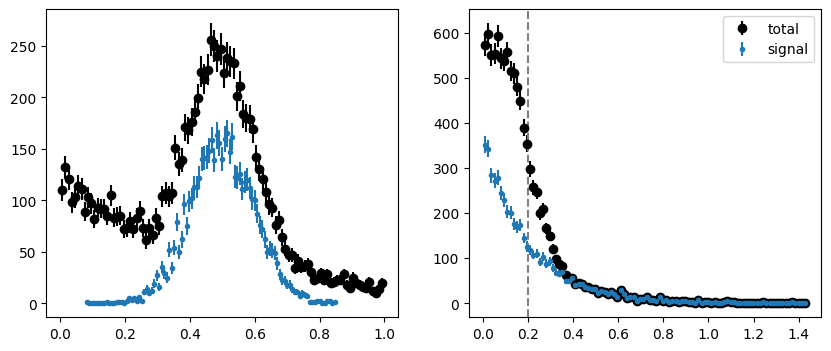

In [2]:
mrange = (0.0, 1.0)
trange = (0.0, 1.5)
tsplit = 0.2

toy = make_classic_toy(1, mrange=mrange, trange=trange)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(ax[0])
plot_binned(toy[0], bins=100, color="k", label="total")
plot_binned(toy[0][toy[2]], bins=100, marker=".", color="C0", label="signal")
plt.sca(ax[1])
plot_binned(toy[1], bins=100, color="k", label="total")
plot_binned(toy[1][toy[2]], bins=100, marker=".", color="C0", label="signal")
plt.axvline(tsplit, ls="--", color="0.5")
plt.legend();

We use a mask to split our toy dataset and plot both parts along the $m$ variable.

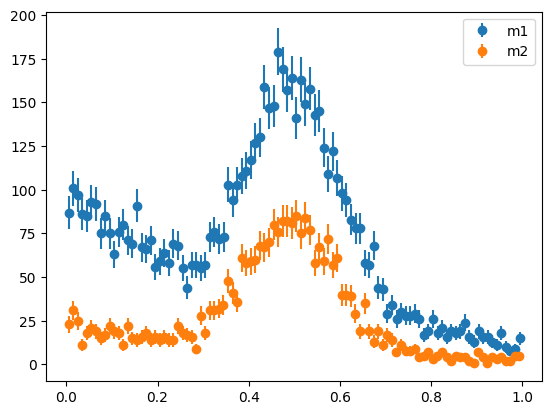

In [3]:
mask = toy[1] < tsplit
m1 = toy[0][mask]
m2 = toy[0][~mask]

plot_binned(m1, bins=100, label="m1")
plot_binned(m2, bins=100, label="m2")
plt.legend();

For sWeights to be applicable, the pdfs in the $m$ variable must not depend on the $t$ variable. The respective yields are allowed to vary, but the shape parameters of the pdfs for signal and background must be identical. We can test this null hypothesis against the alternative (shape parameters are not the same) with a likelihood ratio test. This only requires parametric models for the signal and background densities in the $m$ variable, which are needed anyway to compute sWeights. Hence, this technique is easy to use in practice.

Here, the $m$ distribution consists of a normal distribution for the signal and exponential background, which have the parameters $\mu,\sigma$ and $\lambda$, respectively. In case of the null hypothesis, the two datasets share these parameters, but the signal and background yields $s,b$ are allowed to differ. In case of the alternative hypothesis, all parameters are determined separately for the two partial datasets. The $Q$ statistic
$$
Q = -2\ln\frac{\sup L_{H_0}}{\sup L_{H_1}} = -2\ln\frac{\sup\{ L_1(s_1, b_1, \mu, \sigma, \lambda) L_2(s_2, b_2, \mu, \sigma, \lambda) \}}{\sup \{ L_1(s_1, b_1, \mu_1, \sigma_1, \lambda_1) L_2(s_2, b_2, \mu_2, \sigma_2, \lambda_2) \}}
$$
is asymptotically chi-square distributed with 3 degrees of freedom, since that is the difference in dimensionality in the parameter space between $H_0$ and $H_1$. Note, that the likelihood ratio test requires $H_0$ to be nested in $H_1$, and that is the case here.

We first fit $H_0$ with iminuit. We use an extended unbinned maximum likelihood method, but one could also use a binned maximum likelihood method or the classic method instead of the extended method. Our choice is merely the most convenient.

For the cost function `ExtendedUnbinnedNLL` from iminuit, we create `model`, a function that returns the integral of the density as the first argument and the density as the second argument (see the documentation of `ExtendedUnbinnedNLL`). We use type annotations to indicate that some parameters have lower bounds.

In [4]:
def model(
    x,
    s: PositiveFloat,
    b: PositiveFloat,
    mu: PositiveFloat,
    sigma: PositiveFloat,
    slope: PositiveFloat,
):
    ds = norm(mu, sigma)
    snorm = np.diff(ds.cdf(mrange))

    db = expon(0, slope)
    bnorm = np.diff(db.cdf(mrange))

    integral = s + b
    density = s / snorm * ds.pdf(x) + b / bnorm * db.pdf(x)
    return integral, density

Then we create the `ExtendedUnbinnedNLL`, one for each partial data set, add them (adding log-likelihoods is equivalent to multiplying the likelihoods) and fit the sum.

iminuit detects the parameters from the function signature. Since the same function `model` is used in both instances of `ExtendedUnbinnedNLL`, all parameters would be shared. But we don't want that to happen for the yields, so we use the utility function `make_with_signature` to rename the yield parameters of our model, to make them distinct.

In [5]:
nll1 = ExtendedUnbinnedNLL(m1, make_with_signature(model, s="s1", b="b1"))
nll2 = ExtendedUnbinnedNLL(m2, make_with_signature(model, s="s2", b="b2"))
mi0 = Minuit(
    nll1 + nll2,
    s1=1000,
    s2=1000,
    b1=1000,
    b2=1000,
    mu=0.5,
    sigma=0.1,
    slope=0.5,
)
mi0.strategy = 0  # sufficient since we don't need accurate parameter errors
mi0.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.567e+05                 │              Nfcn = 184              │
│ EDM = 5.35e-06 (Goal: 0.0002)    │            time = 1.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s1    │  3.13e3   │  0.08e3   │            │            │    0    │         │       │
│ 1 │ b1    │  4.07e3   │  0.09e3   │            │            │    0    │         │       │
│ 2 │ mu    │  0.4976   │  0.0019   │            │            │    0    │         │       │
│ 3 │ sigma │  0.0978   │  0.0018   │            │            │    0    │         │       │
│ 4 │ slope │   0.501   │   0.015   │            │            │    0    │         │       │
│ 5 │ s2    │  1.81e3   │  0.05e3   │            │            │    0    │         │       │
│ 6 │ b2    │    960    │    40     │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────────────────┐
│       │          s1          b1          mu       sigma       slope          s2          b2 │
├───────┼─────────────────────────────────────────────────────────────────────────────────────┤
│    s1 │    7.03e+03        -4e3  -4.5308e-3  62.5754e-3  -458.83e-3       0.6e3      -0.6e3 │
│    b1 │        -4e3    7.52e+03   7.6545e-3 -60.1401e-3   377.01e-3      -0.6e3       0.5e3 │
│    mu │  -4.5308e-3   7.6545e-3    3.45e-06     -0.4e-6     -3.3e-6  -5.8080e-3   6.5633e-3 │
│ sigma │  62.5754e-3 -60.1401e-3     -0.4e-6    3.42e-06     -8.1e-6  25.8622e-3 -25.9445e-3 │
│ slope │  -458.83e-3   377.01e-3     -3.3e-6     -8.1e-6    0.000234  -137.73e-3   125.24e-3 │
│    s2 │       0.6e3      -0.6e3  -5.8080e-3  25.8622e-3  -137.73e-3    2.62e+03      -0.9e3 │
│    b2 │      -0.6e3       0.5e3   6.5633e-3 -25.9445e-3   125.24e-3      -0.9e3    1.81e+03 │
└───────┴─────────────────────────────────────────────────────────────────────────────────────┘

To fit $H_1$ with iminuit, we could follow the same strategy, but there is a better way. Since none of the parameters are shared now, it is equivalent to optimize the log-likelihood for each dataset separately and add the results. We avoid optimizing a combined likelihood and renaming model parameters.

In [6]:
nll = ExtendedUnbinnedNLL(m1, model)
mi1 = Minuit(nll, s=1000, b=1000, mu=0.5, sigma=0.1, slope=0.5)
mi1.strategy = 0
mi1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.163e+05                 │              Nfcn = 132              │
│ EDM = 3.78e-06 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  3.10e3   │  0.09e3   │            │            │    0    │         │       │
│ 1 │ b     │  4.09e3   │  0.09e3   │            │            │    0    │         │       │
│ 2 │ mu    │  0.5014   │  0.0026   │            │            │    0    │         │       │
│ 3 │ sigma │  0.0967   │  0.0025   │            │            │    0    │         │       │
│ 4 │ slope │   0.500   │   0.018   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────┐
│       │           s           b          mu       sigma       slope │
├───────┼─────────────────────────────────────────────────────────────┤
│     s │    7.97e+03        -5e3  -11.426e-3  110.353e-3  -638.31e-3 │
│     b │        -5e3    8.26e+03    6.357e-3 -113.163e-3   596.99e-3 │
│    mu │  -11.426e-3    6.357e-3    6.54e-06       -0e-6       -9e-6 │
│ sigma │  110.353e-3 -113.163e-3       -0e-6    6.45e-06      -14e-6 │
│ slope │  -638.31e-3   596.99e-3       -9e-6      -14e-6    0.000343 │
└───────┴─────────────────────────────────────────────────────────────┘

We can safely ignore the remark that the covariance matrix is approximate.

In [7]:
nll = ExtendedUnbinnedNLL(m2, model)
mi2 = Minuit(nll, s=1000, b=1000, mu=0.5, sigma=0.1, slope=0.5)
mi2.strategy = 0
mi2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.043e+04                 │              Nfcn = 102              │
│ EDM = 5.79e-05 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  1.83e3   │  0.06e3   │            │            │    0    │         │       │
│ 1 │ b     │    940    │    50     │            │            │    0    │         │       │
│ 2 │ mu    │  0.4928   │  0.0032   │            │            │    0    │         │       │
│ 3 │ sigma │  0.0990   │  0.0028   │            │            │    0    │         │       │
│ 4 │ slope │   0.50    │   0.04    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────────────────────────────────┐
│       │          s          b         mu      sigma      slope │
├───────┼────────────────────────────────────────────────────────┤
│     s │   3.19e+03     -1.4e3   3.115e-3  61.094e-3    -0.7619 │
│     b │     -1.4e3   2.31e+03    -970e-6 -61.182e-3     0.7594 │
│    mu │   3.115e-3    -970e-6   9.93e-06      -1e-6     -29e-6 │
│ sigma │  61.094e-3 -61.182e-3      -1e-6   7.61e-06     -31e-6 │
│ slope │    -0.7619     0.7594     -29e-6     -31e-6    0.00157 │
└───────┴────────────────────────────────────────────────────────┘

The class `ExtendedUnbinnedNLL` computes the equivalent of $-2 \ln L$. Thus, to compute the $Q$ statistic, we therefore can add the minimum values of the two cost functions for $H_1$ and subtract them from $H_0$. The degrees of freedom are obtained by subtracting the number parameters for $H_0$ from $H_1$.

In [8]:
# difference in number of parameters for H1 and H0
ndof = (mi1.nfit + mi2.nfit) - mi0.nfit  
# test statistic, which is asymptotically chi-square distributed
q = mi0.fval - (mi1.fval + mi2.fval)
pvalue = chi2(ndof).sf(q)
pvalue

0.16428688931432733

With a chance probability of 26 % we won't reject the null. 

Let's try this again for a toy dataset where the factorization requirement is not fulfilled. We artificially make the mean of the signal PDF in $m$ a function of the $t$ variable. This breaks factorization, because the parameter $\mu$ is now a function of $t$.

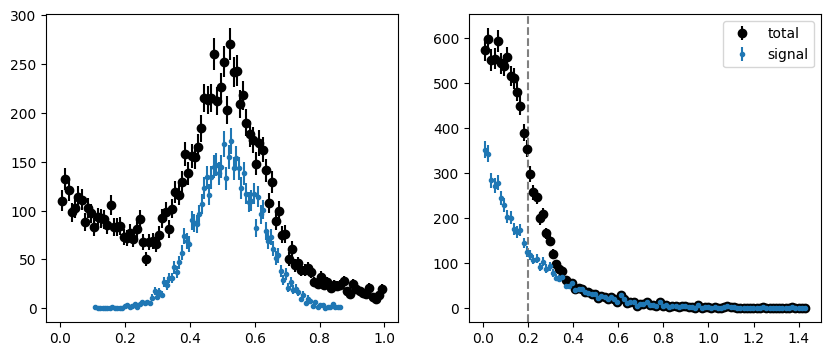

In [9]:
# save the original toy for later
toy_original = (toy[0].copy(), toy[1].copy(), toy[2].copy())

# modify the toy to introduce non-factorization
tm = toy[2]
toy[0][tm] += 0.1 * toy[1][tm]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(ax[0])
plot_binned(toy[0], bins=100, color="k", label="total")
plot_binned(toy[0][toy[2]], bins=100, marker=".", color="C0", label="signal")
plt.sca(ax[1])
plot_binned(toy[1], bins=100, color="k", label="total")
plot_binned(toy[1][toy[2]], bins=100, marker=".", color="C0", label="signal")
plt.axvline(tsplit, ls="--", color="0.5")
plt.legend();

This change is hardly noticeable when we plot the full dataset. It becomes more apparent when we plot the distributions after splitting (we split in the same way as before).

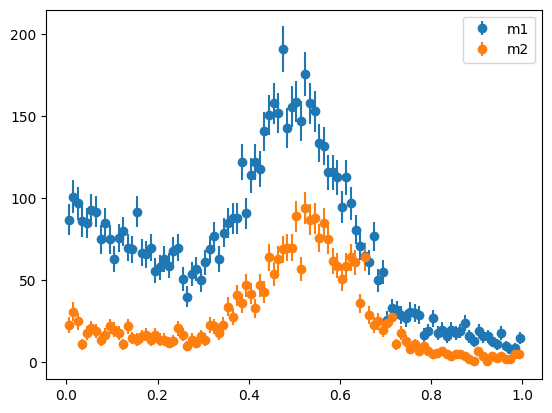

In [10]:
mask = toy[1] < tsplit
m1 = toy[0][mask]
m2 = toy[0][~mask]

plot_binned(m1, bins=100, label="m1")
plot_binned(m2, bins=100, label="m2")
plt.legend();

We can see now that the peaks are not at the same place, but the deviation could be more subtle. A change in the width of the peak or the slope of the background would be harder to detect by eye. Or there could be several changes in the shape variables at once, each individually too small to be noticeable.

In any case, we need a p-value to quantify whether such a deviation is significant, which is provided by the likelihood-ratio test.

In [11]:
nll1 = ExtendedUnbinnedNLL(m1, make_with_signature(model, s="s1", b="b1"))
nll2 = ExtendedUnbinnedNLL(m2, make_with_signature(model, s="s2", b="b2"))
mi0 = Minuit(
    nll1 + nll2,
    s1=1000,
    s2=1000,
    b1=1000,
    b2=1000,
    mu=0.5,
    sigma=0.1,
    slope=0.5,
)
mi0.strategy = 0  # sufficient since we don't need accurate parameter errors
mi0.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.565e+05                 │              Nfcn = 201              │
│ EDM = 7.62e-07 (Goal: 0.0002)    │            time = 0.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s1    │  3.14e3   │  0.08e3   │            │            │    0    │         │       │
│ 1 │ b1    │  4.06e3   │  0.09e3   │            │            │    0    │         │       │
│ 2 │ mu    │  0.5199   │  0.0020   │            │            │    0    │         │       │
│ 3 │ sigma │  0.1002   │  0.0019   │            │            │    0    │         │       │
│ 4 │ slope │   0.489   │   0.016   │            │            │    0    │         │       │
│ 5 │ s2    │  1.84e3   │  0.05e3   │            │            │    0    │         │       │
│ 6 │ b2    │    930    │    40     │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────────────────────────────────────────────────────────────────────────┐
│       │         s1         b1         mu      sigma      slope         s2         b2 │
├───────┼──────────────────────────────────────────────────────────────────────────────┤
│    s1 │   7.11e+03       -4e3 -14.102e-3  69.984e-3 -520.18e-3      0.7e3     -0.7e3 │
│    b1 │       -4e3   7.48e+03  12.494e-3 -70.781e-3  529.73e-3     -0.6e3      0.6e3 │
│    mu │ -14.102e-3  12.494e-3   3.82e-06      -0e-6      -4e-6  -1.380e-3     789e-6 │
│ sigma │  69.984e-3 -70.781e-3      -0e-6   3.78e-06     -12e-6  29.984e-3 -28.380e-3 │
│ slope │ -520.18e-3  529.73e-3      -4e-6     -12e-6   0.000262 -163.01e-3  204.76e-3 │
│    s2 │      0.7e3     -0.6e3  -1.380e-3  29.984e-3 -163.01e-3   2.63e+03     -0.9e3 │
│    b2 │     -0.7e3      0.6e3     789e-6 -28.380e-3  204.76e-3     -0.9e3   1.74e+03 │
└───────┴──────────────────────────────────────────────────────────────────────────────┘

In [12]:
nll = ExtendedUnbinnedNLL(m1, model)
mi1 = Minuit(nll, s=1000, b=1000, mu=0.5, sigma=0.1, slope=0.5)
mi1.strategy = 0
mi1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.163e+05                 │              Nfcn = 118              │
│ EDM = 7.28e-07 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  3.12e3   │  0.09e3   │            │            │    0    │         │       │
│ 1 │ b     │  4.08e3   │  0.09e3   │            │            │    0    │         │       │
│ 2 │ mu    │  0.5095   │  0.0026   │            │            │    0    │         │       │
│ 3 │ sigma │  0.0973   │  0.0026   │            │            │    0    │         │       │
│ 4 │ slope │   0.499   │   0.019   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────┐
│       │           s           b          mu       sigma       slope │
├───────┼─────────────────────────────────────────────────────────────┤
│     s │    7.94e+03        -4e3  -16.057e-3  107.648e-3  -621.59e-3 │
│     b │        -4e3    8.41e+03   14.143e-3 -113.809e-3   675.24e-3 │
│    mu │  -16.057e-3   14.143e-3    6.64e-06       -0e-6       -9e-6 │
│ sigma │  107.648e-3 -113.809e-3       -0e-6    6.89e-06      -16e-6 │
│ slope │  -621.59e-3   675.24e-3       -9e-6      -16e-6    0.000347 │
└───────┴─────────────────────────────────────────────────────────────┘

In [13]:
nll = ExtendedUnbinnedNLL(m2, model)
mi2 = Minuit(nll, s=1000, b=1000, mu=0.5, sigma=0.1, slope=0.5)
mi2.strategy = 0
mi2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.029e+04                 │              Nfcn = 103              │
│ EDM = 0.000123 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  1.83e3   │  0.06e3   │            │            │    0    │         │       │
│ 1 │ b     │    950    │    50     │            │            │    0    │         │       │
│ 2 │ mu    │  0.5331   │  0.0030   │            │            │    0    │         │       │
│ 3 │ sigma │  0.1008   │  0.0028   │            │            │    0    │         │       │
│ 4 │ slope │   0.50    │   0.04    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────────────────────────────────┐
│       │          s          b         mu      sigma      slope │
├───────┼────────────────────────────────────────────────────────┤
│     s │   3.39e+03     -1.5e3  -4.411e-3  60.772e-3    -1.1197 │
│     b │     -1.5e3   2.48e+03   6.554e-3 -62.618e-3     1.1090 │
│    mu │  -4.411e-3   6.554e-3   9.19e-06      -1e-6     -18e-6 │
│ sigma │  60.772e-3 -62.618e-3      -1e-6   7.89e-06     -39e-6 │
│ slope │    -1.1197     1.1090     -18e-6     -39e-6    0.00193 │
└───────┴────────────────────────────────────────────────────────┘

In [14]:
# difference in number of parameters for H1 and H0
ndof = (mi1.nfit + mi2.nfit) - mi0.nfit
# test statistic, which is asymptotically chi-square distributed
q = mi0.fval - (mi1.fval + mi2.fval)
pvalue = chi2(ndof).sf(q)
pvalue

1.253769135376934e-08

In [15]:
norm.isf(pvalue)

5.572746842381205

Now the p-value is $1.7\times 10^{-9}$, equivalent to a $5.9\,\sigma$ deviation from a normal distribution. In this case, we should reject the null hypothesis.

## Alternative: Kendall's tau test

The Kendall's tau test is a simple test you can apply if you have pure samples from the signal and background components available. In general, you won't have these, because if you did, you would not need sWeights in the first place.

A pure background sample can be obtained from data, by selecting samples from the side-bands around the signal peak. For the signal, you can usually only get it from Monte-Carlo simulation of the experiment. You need to trust the simulation then.

The Kendall's tau test checks whether two variables are independent and returns a p-value for that null hypothesis. You should apply this test to each component. If the p-values for a component is very small, you cannot compute classic sWeights, although you can still use COWs after expanding the component into many sub-components. To apply the classic sWeights, all components must pass the test.

We first apply the test to the signal and background samples in the original toy, where these components factorize, to see that it passes.

In [16]:
from sweights.independence import kendall_tau

In [17]:

m, t, truth_mask = toy_original

m_sig = m[truth_mask]
t_sig = t[truth_mask]

val, err, pvalue = kendall_tau(m_sig, t_sig)
pvalue

0.09029195168931155

In [18]:
m_bkg = m[~truth_mask]
t_bkg = t[~truth_mask]

val, err, pvalue = kendall_tau(m_bkg, t_bkg)
pvalue

0.7015075243963227

Both components pass the test, neither p-value is very small ($\ll 0.01$).

**Warning**: As already said, you cannot apply the test to the mixed sample. The mixed sample does not factorize, even if the components separately factorize.

In [19]:
val, err, pvalue = kendall_tau(m, t)
pvalue

0.00588671692380863

Now we apply the test to the modified toy which violates the factorization requirement.

In [20]:
m, t, truth_mask = toy

m_sig = m[truth_mask]
t_sig = t[truth_mask]

val, err, pvalue = kendall_tau(m_sig, t_sig)
pvalue

1.9412926161716674e-24

In [21]:
m_bkg = m[~truth_mask]
t_bkg = t[~truth_mask]

val, err, pvalue = kendall_tau(m_bkg, t_bkg)
pvalue

0.7015075243963227

We find that the signal component does not pass the factorization test, but the background does. That is exactly what we expect, since we only modified the signal component.

As mentioned, a pure background sample can also be obtained by selecting events from the side bands without knowing true labels. We see that a sample from the side band passes our test, even though the signal region would fail it.

In [23]:
ma = (m < 0.2) | (m > 0.8)
m_bkg = m[ma]
t_bkg = t[ma]

val, err, pvalue = kendall_tau(m_bkg, t_bkg)
pvalue

0.3855929053284022